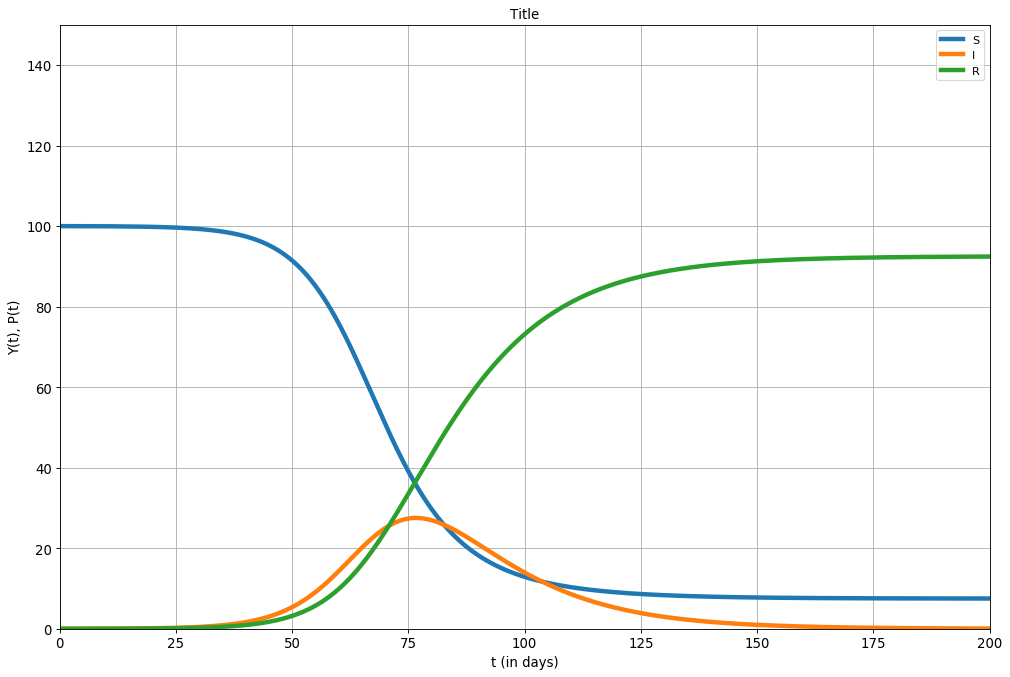

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
import scipy.stats


Dt = 0.01               # timestep Delta t
 
S_start=100 #healthy but can be infected 
I_start=0.01 #infectious
R_start=0 #recovered

N=S_start+I_start+R_start
#mu 
# beta is avg contact and gamma - recovery rate, gamma is kinda fixed

beta,gamma= 0.2,1/14
            
t_start = 0             # starttime
t_end = 200              # endtime
n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps


S_arr = np.zeros(n_steps +1)
I_arr = np.zeros(n_steps +1)
R_arr=np.zeros(n_steps +1)

t_arr = np.zeros(n_steps + 1) 

t_arr[0] = t_start    

S_arr[0] =S_start   
I_arr[0]=I_start
R_arr[0]=R_start


# Euler's method
for i in range (1, n_steps + 1):  
       
        S = S_arr[i-1]
        I = I_arr[i-1]
        R = R_arr[i-1]
        t = t_arr[i-1]
        
        dSdt = -beta*I*S/N          # calculate the derivative of 
        dIdt=beta*I*S/N -gamma*I
        dRdt=gamma*I
        #dRdt=-dSdt-dEdt-dIdt
        
        S_arr[i] = S + Dt*dSdt  # calc.  at next timestep,add to array
        I_arr[i] = I + Dt*dIdt
        R_arr[i] = R + Dt*dRdt
        t_arr[i] = t + Dt       # add new value of t to array
        
# plotting the result
fig = plt.figure(figsize=(15, 10), dpi=80)                                  # create figure
plt.plot(t_arr, S_arr, linewidth = 4, label = 'S')    # plot Y to t 

plt.plot(t_arr, I_arr, linewidth = 4, label = 'I') 
plt.plot(t_arr, R_arr, linewidth = 4, label = 'R') 
plt.title('Title', fontsize = 12)    
plt.xlabel('t (in days)', fontsize = 12)
plt.ylabel('Y(t), P(t)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(True)                        # show grid
plt.axis([t_start, t_end, 0, 150])     # show axes measures
plt.legend()
plt.show()


In [2]:
def get_inf(beta,scale,duration, gamma = 1/14):
    Dt = 0.01               # timestep Delta t
    S_start=99.9 #healthy but can be infected 
    I_start=0.01 #infectious
    R_start=0 #recovered

    N=S_start+I_start+R_start
    #mu 
    # beta is avg contact and gamma - recovery rate, gamma is kinda fixed


    t_start = 0#loc    
    t_end = duration #+loc             endtime
    n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps


    S_arr = np.zeros(n_steps +1)
    I_arr = np.zeros(n_steps +1)
    R_arr=np.zeros(n_steps +1)

    t_arr = np.zeros(n_steps + 1) 

    t_arr[0] = t_start    

    S_arr[0] =S_start   
    I_arr[0]=I_start
    R_arr[0]=R_start


    # Euler's method
    for i in range (1, n_steps + 1):  

            S = S_arr[i-1]
            I = I_arr[i-1]
            R = R_arr[i-1]
            t = t_arr[i-1]

            dSdt = -beta*I*S/N          # calculate the derivative of 
            dIdt=beta*I*S/N -gamma*I
            dRdt=gamma*I
            #dRdt=-dSdt-dEdt-dIdt

            S_arr[i] = S + Dt*dSdt  # calc.  at next timestep,add to array
            I_arr[i] = I + Dt*dIdt
            R_arr[i] = R + Dt*dRdt
            t_arr[i] = t + Dt   # add new value of t to array
            
          
    return I_arr*scale

In [3]:
def movavg(data):
    return [np.mean(data[i-7:i]) for i in range(7,len(data))]

In [5]:

df = pd.read_csv(r"C:\Users\Dima\Downloads\WHO-COVID-19-global-data (1).csv")

netherlands = df[df['Country']=='Netherlands']
dates = list(netherlands['Date_reported'].values)
#netherlands.describe()
netherlands

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
73730,2020-01-03,NL,Netherlands,EURO,0,0,0,0
73731,2020-01-04,NL,Netherlands,EURO,0,0,0,0
73732,2020-01-05,NL,Netherlands,EURO,0,0,0,0
73733,2020-01-06,NL,Netherlands,EURO,0,0,0,0
73734,2020-01-07,NL,Netherlands,EURO,0,0,0,0
...,...,...,...,...,...,...,...,...
74230,2021-05-17,NL,Netherlands,EURO,4440,1598011,13,17449
74231,2021-05-18,NL,Netherlands,EURO,2867,1600878,7,17456
74232,2021-05-19,NL,Netherlands,EURO,5353,1606231,17,17473
74233,2021-05-20,NL,Netherlands,EURO,4581,1610812,15,17488


 That's a complex because we kinda don't have explanattory variables So we do $y = f(\beta)+\epsilon$, where $f(\beta)$ set of points of infected people for possible set of parameteres. And y is the actual number of infected people, and well, we'll just minimise SSR over $\beta$. We dont estime $\gamma$ - because it's known

In [51]:
# return sum of squared residuals for given parameters and data
def get_SSR(x):
        beta = x[0]
        scale = x[1]
        start = x[2]
        end=x[3]
        #level = x[4]
        cases = netherlands['New_cases'][int(start):int(end)].values

        cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))

        num_inf = movavg(cases) #maybe allow for moving dates 
        theory_num = get_inf(beta=beta,scale=scale,duration=len(num_inf), gamma = 1/14)
        theory_num=theory_num[::100][1:]

        return  (np.sum([(num_inf[i]-theory_num[i])**2 for i in range(len(num_inf))]))
    
    
# do optimisation, plot graphs, obtain some statistics
def do_all(start=10, end=90, margin = 5):
    start_values=[start - margin, start + margin]
    end_values=[end - margin,end+margin]


    bounds = Bounds((0, 0, start_values[0], end_values[0] ), (1.0, 0.08, start_values[1],end_values[1]))
    result = minimize(get_SSR, x0=[0.3,0.03,(start_values[0]+start_values[1])/2,(end_values[0]+end_values[1])/2],method='L-BFGS-B', bounds = bounds)
    print(result)


    fig = plt.figure(figsize=(15, 10), dpi=80) 


    opt_param = result['x']

    cases = netherlands['New_cases'][int(opt_param[2]):int(opt_param[3])].values
    cases = list(map(lambda x: x/(max(cases)-min(cases)) , cases ))

    plt.plot(range(len(movavg(cases))) ,movavg(cases), linewidth = 4)

    theory_num = get_inf(beta=opt_param[0],scale=opt_param[1],duration=-int(opt_param[2])+int(opt_param[3]))
    x=theory_num[::100][1:]
    
    
    #plt.title('Figure 3. Fitted curve and weekly moving average for netherlands no measures', fontsize = 20)    
    plt.xlabel('time (in days)', fontsize = 20)
    plt.ylabel('share of infections', fontsize = 20)
    plt.plot(x,linewidth = 4 )
    plt.show()

    residuals = [(movavg(cases)[i] - x[i]) for i in range(len(movavg(cases)))]

    SSR = np.sum([i**2 for i in residuals])
    print('SSR '+str(SSR))
    pearson_chisq= np.sum([((movavg(cases)[i] - x[i])/ x[i])**2 for i in range(len(movavg(cases)))])
    print('pearson_chisq ' + str(pearson_chisq))
    #GTest = 2* np.sum([movavg(cases)[i]*np.log(movavg(cases)[i]/x[i]) for i in range(len(movavg(cases)))])
    #print("GTest " + str(GTest))
    return opt_param


We'll use chow test to see if we can estimate model on parts with no restrictions to forecast part with restrictions $F = \frac {SSR_0-SS1_1 / n_2}{SSR_1/n1-k}$, where SSR1 is a fit for full model, SSR0 is a fit for part with no measures. We do our optimisation on part with no measures and big regression is part with no measures + 50 points
No 

In [ ]:
def get_summary():
    p_0 = do_all(start_values=[0,20],end_values=[85,95])
    p_1 = do_all(start_values=[0,20],end_values=[85+50,95+50])
    SSR_1 = get_SSR(p_1)
    SSR_0 = get_SSR([p_0[1],p_0[1],p_0[2],p_1[3]-p_1[2]])
    
    print('the beta change moving from no measures to model with measures is '+ str(p_1[0]-p_0[0]))
    F = (SSR_0-SSR_1)/(p_1[3]-p_1[2] - p_0[3]+p_0[2]) / (SSR_1 /(p_1[3]-p_1[2]-3) )
    print('Chow forecast test statistics is ' + str(F))
    print('Critical value is ' + str(scipy.stats.f.ppf(0.95,(p_1[3]-p_1[2] - p_0[3]+p_0[2]) ,(p_1[3]-p_1[2]-3))))
    
get_summary()

In [31]:
#now let's do a simplified version to do optimisation, and get beta
def get_beta(start=10, end=90, margin = 10 ):
    start_values=[start - margin, start + margin]
    end_values=[end - margin,end+margin]
    
    bounds = Bounds((0, 0, start_values[0], end_values[0] ), (1.0, 0.08, start_values[1],end_values[1]))
    result = minimize(get_SSR, x0=[0.2,0.03,(start_values[0]+start_values[1])/2,(end_values[0]+end_values[1])/2],method='L-BFGS-B', bounds = bounds)
    
    
    return(result['x'][0])

get_beta()


0.17332873012793798

We will split waves in the following intervals: 

6th march 2020 - 11th May (first death - ease of strict measures)

11th May - 18th August (ease of strict measures - fisrt measure after ease introduced)

18th August - 14th December (fisrt measure -  strict rules intrduced) *wave with light measures*

14th December - 21st January (strict rules - first curfew) *wave with harder measures*

21st January - 19th May (first curfew - most measures removed) *not really wave, more like pushing it cases down with hard measures*



In [32]:
print(get_beta (dates.index('2020-03-06'), dates.index('2020-05-11')))
print(get_beta (dates.index('2020-05-11'), dates.index('2020-08-18')))
print(get_beta (dates.index('2020-08-18'), dates.index('2020-11-01')))
print(get_beta (dates.index('2020-11-01'), dates.index('2021-01-21')))
print(get_beta (dates.index('2021-01-21'), dates.index('2021-05-19')))

0.49076247889870955
0.15455713544324756
0.23681069256440032
0.2967798921856431
0.19952918496391633


      fun: 2.8241660761972796
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.24344979e-06, -2.62012634e-06,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 55
      nit: 8
   status: 0
  success: True
        x: array([4.90762432e-01, 1.88695129e-02, 6.30000000e+01, 1.29000000e+02])


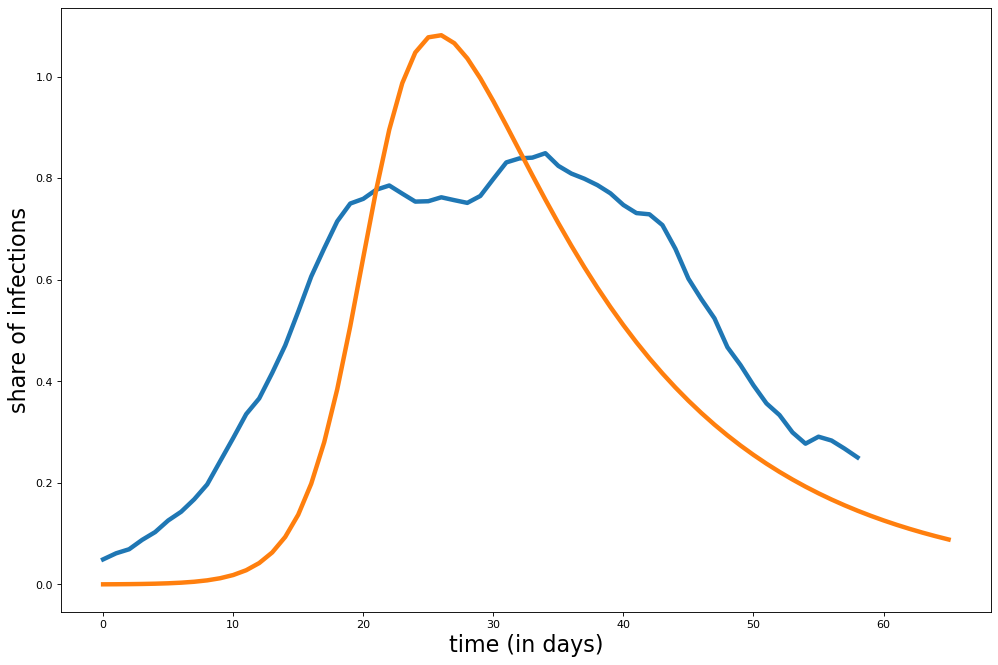

SSR 2.8241660761972796
pearson_chisq 78249.43635597454
[4.90762432e-01 1.88695129e-02 6.30000000e+01 1.29000000e+02]
      fun: 1.9329149785401345
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.88657986e-06, -8.47876702e-01,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 140
      nit: 6
   status: 0
  success: True
        x: array([1.53513273e-01, 8.00000000e-02, 1.29000000e+02, 2.28000000e+02])


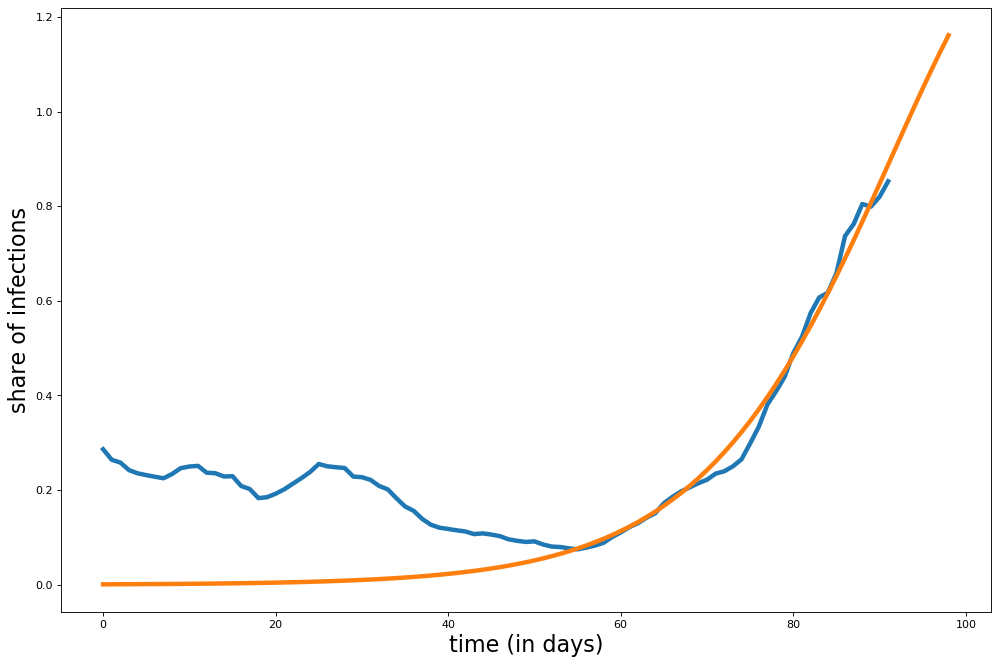

SSR 1.9329149785401345
pearson_chisq 535347.9651954243
[1.53513273e-01 8.00000000e-02 1.29000000e+02 2.28000000e+02]
      fun: 0.6452509941319483
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.66293670e-07,  3.99680289e-07,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 50
      nit: 8
   status: 0
  success: True
        x: array([2.28706226e-01, 2.86257809e-02, 2.28000000e+02, 3.16000000e+02])


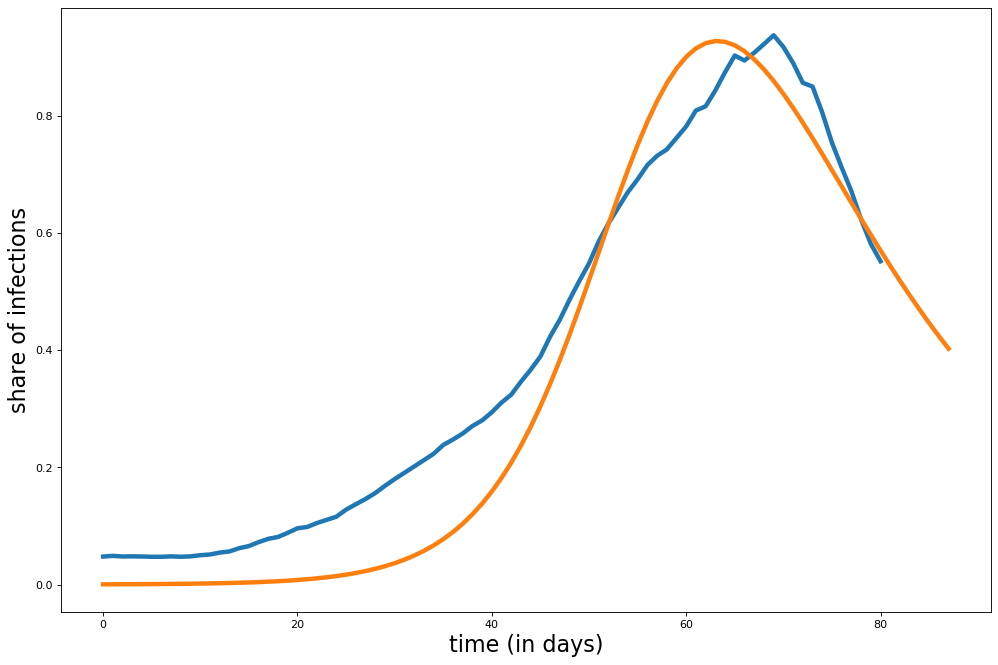

SSR 0.6452509941319483
pearson_chisq 76059.439520706
[2.28706226e-01 2.86257809e-02 2.28000000e+02 3.16000000e+02]
      fun: 8.022129031365411
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.79616347e-06, -8.34887715e-06,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 70
      nit: 9
   status: 0
  success: True
        x: array([3.99106719e-01, 2.88056628e-02, 3.16000000e+02, 3.84000000e+02])


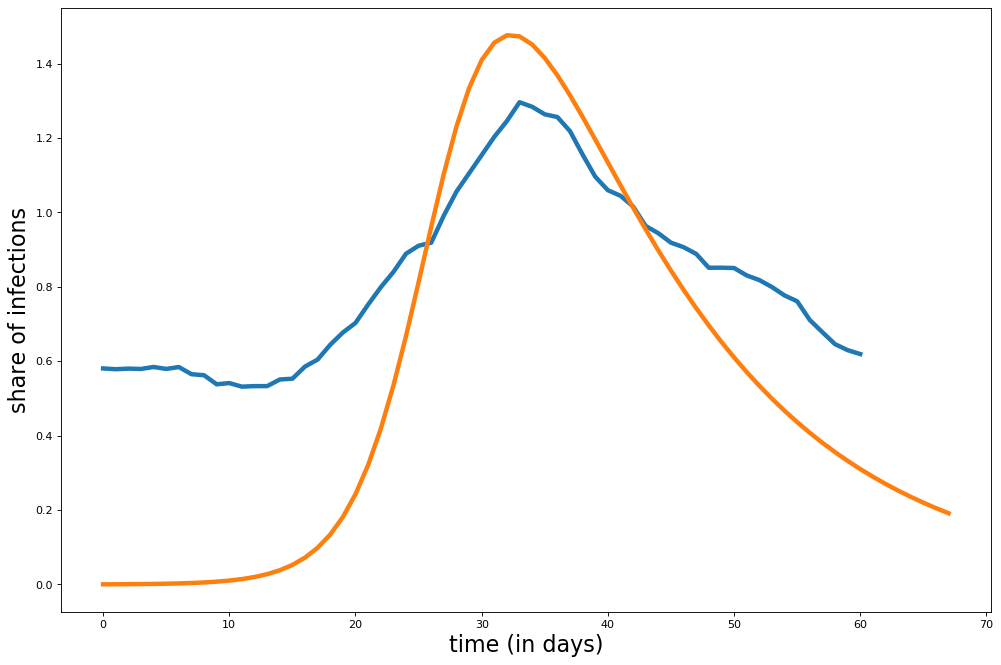

SSR 8.022129031365411
pearson_chisq 4377393.448429322
[3.99106719e-01 2.88056628e-02 3.16000000e+02 3.84000000e+02]
      fun: 17.559954800364054
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.59232693e-06, -2.13162821e-06,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 9
   status: 0
  success: True
        x: array([1.99529187e-01, 4.60425908e-02, 3.84000000e+02, 5.02000000e+02])


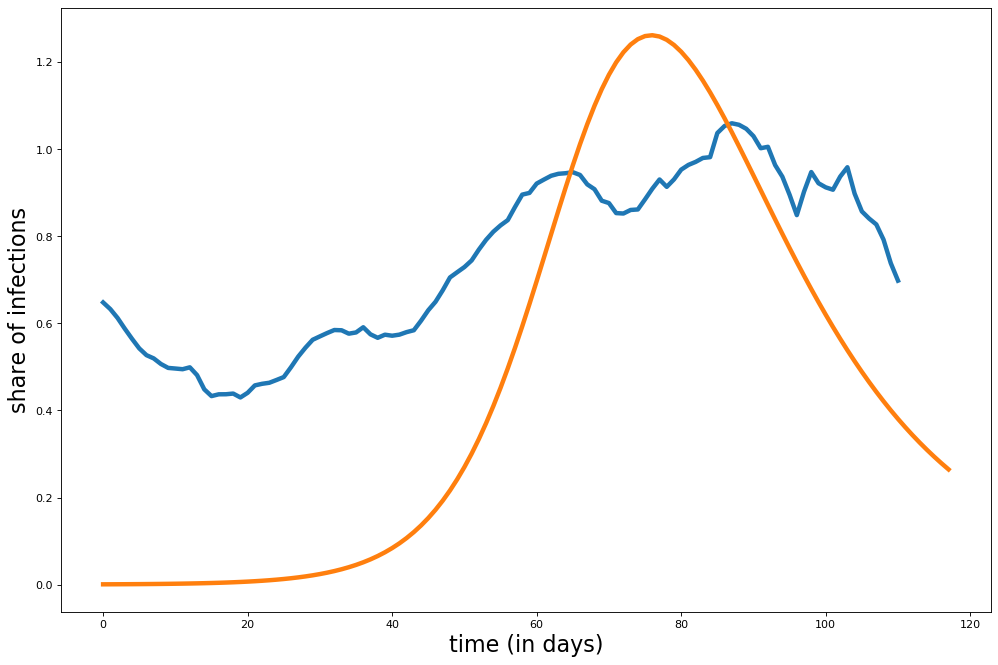

SSR 17.559954800364054
pearson_chisq 5652854.984624894
[1.99529187e-01 4.60425908e-02 3.84000000e+02 5.02000000e+02]


In [52]:
print(do_all (dates.index('2020-03-06'), dates.index('2020-05-11')))
print(do_all (dates.index('2020-05-11'), dates.index('2020-08-18')))
print(do_all (dates.index('2020-08-18'), dates.index('2020-11-14')))
print(do_all (dates.index('2020-11-14'), dates.index('2021-01-21'), margin = 10))
print(do_all (dates.index('2021-01-21'), dates.index('2021-05-19'), margin = 10))